# Download checkpoint

In [ ]:
!rm checkpoint_mae_pretrained.pt

In [ ]:
%%writefile download.sh
FILE_NAME='/kaggle/working/checkpoint_mae_pretrained.pt'
FILE_ID='1VanxPChGPGcOj93h41lDcjee-7GpZXi9'
curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=$FILE_ID" > /dev/null
CODE="$(awk '/_warning_/ {print $NF}' /tmp/cookie)"  
curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=${CODE}&id=$FILE_ID" -o $FILE_NAME

In [ ]:
!bash download.sh

# Import library

In [1]:
!pip -q install einops wandb graphviz torchview

In [2]:
import warnings
warnings.filterwarnings('ignore')

from skimage import io, transform
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

import wandb
import random
import math
import numpy as np
from IPython.display import clear_output

from tqdm.notebook import trange, tqdm

import torch.nn.functional as F
import torch.optim as optim
import einops
from einops import rearrange

from scipy.ndimage.morphology import grey_dilation

from ray import tune, air
from ray.air import session
from ray.tune.search.optuna import OptunaSearch

from torchview import draw_graph

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Configuration

In [3]:
def seed_anything(seed=2023):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
seed_anything()

In [4]:
IMG_SIZE = 64
BATCH_SIZE = 16

TRAIN_IMG_DIR = '/kaggle/input/aflw-face-crop/images_train/'
TEST_IMG_DIR = '/kaggle/input/aflw-face-crop/images_test/'

TRAIN_ANNOTATION_FILE = '/kaggle/input/aflw-face-crop/train.txt'
TEST_ANNOTATION_FILE = '/kaggle/input/aflw-face-crop/test.txt'

CHECKPOINT_PATH = '/kaggle/working/checkpoint_mae_pretrained.pt'
PROJECT_NAME = 'MAE-AFLW'
API_KEY = '4e1db623bafbe354453dd641bf6fe94566f55a08'

BASE_LR = 1.5e-4
WEIGHT_DECAY = 5e-2
WARMUP_EPOCH = 200
TOTAL_EPOCH = 2000

NUM_POINTS = 19
HEATMAP_SIZE = (64, 64)
SIGMA = 1

RESUME = True

# WanDB

In [5]:
wandb.login(key=API_KEY)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(
    # Set the project where this run will be logged
    project=PROJECT_NAME,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": (BASE_LR * BATCH_SIZE / 256),
        'weight_decay': WEIGHT_DECAY,
        'warmup': WARMUP_EPOCH,
        "epochs": TOTAL_EPOCH,
    })

# Data

* ## Dataset

In [11]:
meanstd_file = 'mean_std.pth'
if os.path.isfile(meanstd_file):
    meanstd = torch.load(meanstd_file)
else:
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for file_name in os.listdir(TRAIN_IMG_DIR):
        img_path = os.path.join(TRAIN_IMG_DIR, file_name)
        img = read_image(img_path) # CxHxW
        img = img.type('torch.FloatTensor')
        img /= 255
        mean += img.view(img.size(0), -1).mean(1)
        std += img.view(img.size(0), -1).std(1)
    mean /= len(os.listdir(TRAIN_IMG_DIR))
    std /= len(os.listdir(TRAIN_IMG_DIR))
    meanstd = {
        'mean': mean,
        'std': std,
        }
    torch.save(meanstd, 'mean_std.pth')
print(meanstd)

{'mean': tensor([0.5237, 0.4257, 0.3735]), 'std': tensor([0.2417, 0.2220, 0.2119])}


* ## DataLoader

In [5]:
class AFLW(Dataset):
    def __init__(self, annotations_file, img_dir, max_samples=None, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        text = None
        self.img_list = []
        self.points = None
        
        num_samples = 0
        
        with open(annotations_file, 'r') as f:
            text = f.readlines()
            self.points = torch.zeros(len(text), NUM_POINTS, 2)
        if max_samples is not None:
            num_samples = max_samples
        else:
            num_samples = len(text)
        for i in range(num_samples):
            token = text[i].strip().split()
            self.img_list.append(os.path.join(img_dir, token[0]))
            self.points[i] = torch.tensor([float(x) for x in token[1:]], dtype=torch.float32).view(NUM_POINTS, 2)
        self.heatmap_type = 'gaussian'

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        image = io.imread(self.img_list[idx])
        target = torch.zeros(NUM_POINTS, HEATMAP_SIZE[0], HEATMAP_SIZE[1])
        tpts = self.points[idx].clone()
        M = np.zeros((NUM_POINTS, HEATMAP_SIZE[0], HEATMAP_SIZE[1]), dtype=np.float32)
        
        for i in range(NUM_POINTS):
            if tpts[i, 1] > 0:
                target[i] = self._generate_target(target[i], tpts[i] * HEATMAP_SIZE[0] - 1, SIGMA)
        if self.transform:
            image = self.transform(image)
            
        for i in range(len(M)):
            M[i] = grey_dilation(target[i], size=(1,1))
        M = np.where(M>=0.5, 1, 0)
        
        meta = {'index': idx, 'pts': self.points[idx]}
        return image, target, M, meta
    
    def _generate_target(self, img, points, sigma, type='Gaussian'):
        # Draw a 2D gaussian
        # Adopted from https://github.com/anewell/pose-hg-train/blob/master/src/pypose/draw.py
        h,w = img.shape
        tmp_size = sigma * 3

        # Check that any part of the gaussian is in-bounds
        x1, y1 = int(points[0] - tmp_size), int(points[1] - tmp_size) # Top-left
        x2, y2 = int(points[0] + tmp_size + 1), int(points[1] + tmp_size + 1) # Bottom right
        if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
            # If not, just return the image as is
            return img

        # Generate gaussian
        size = 6 * sigma + 1
        x = np.arange(0, size, 1, np.float32)
        y = x[:, np.newaxis]
        x0 = y0 = size // 2
        # The gaussian is not normalized, we want the center value to equal 1
        if type == 'Gaussian':
            g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
        elif type == 'Cauchy':
            g = sigma / (((x - x0) ** 2 + (y - y0) ** 2 + sigma ** 2) ** 1.5)


        # Usable gaussian range
        # Determine the bounds of the source gaussian
        g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
        g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1

        # Image range
        img_x_min, img_x_max = max(0, x1), min(x2, w)
        img_y_min, img_y_max = max(0, y1), min(y2, h)

        img[img_y_min:img_y_max, img_x_min:img_x_max] = \
          torch.from_numpy(g[g_y_min:g_y_max, g_x_min:g_x_max])

        return img

In [53]:
from torchvision.transforms import ToTensor, Compose, Normalize
train_dataset = AFLW(TRAIN_ANNOTATION_FILE, TRAIN_IMG_DIR, transform=Compose([ToTensor()])) # Normalize(meanstd['mean'], meanstd['std'])
val_dataset = AFLW(TEST_ANNOTATION_FILE, TEST_IMG_DIR, transform=Compose([ToTensor()]))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
train_img, train_labels, M, meta = next(iter(train_dataloader))
print(f"Feature batch shape: {train_img.shape}")
print(f"Labels batch shape: {train_labels.shape}")
print(meta)

# Visualize Dataset

In [ ]:
train = os.listdir("/kaggle/input/aflw-face-crop/images_train")
test = os.listdir("/kaggle/input/aflw-face-crop/images_test")
print(f"Train files: \t{len(train)}. ---> {train[:3]}")
print(f"Test files:  \t{len(test)}. ---> {test[:3]}")

In [119]:
def visualize_keypoint(begin, end):
    with open(TRAIN_ANNOTATION_FILE, 'r') as f:
        train_text = f.readlines()
        for line in train_text[begin:end+1]:
            line = line.split()
            img = io.imread(os.path.join(TRAIN_IMG_DIR, line[0]))
            for i in range(1, NUM_POINTS * 2, 2):
                x, y = float(line[i]) * IMG_SIZE, float(line[i+1]) * IMG_SIZE
                img = cv2.circle(img, (int(x), int(y)), 0, (0, 255, 0), 1)
            plt.figure()
            plt.imshow(img)

In [30]:
def visualize_heatmap(idx):
    fig, axes = plt.subplots(4, 5, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if(i == 19):
            break
        heatmap = ax.imshow(train_dataset[idx][1][i], cmap='hot', interpolation='nearest')
        ax.set_title(f'Heatmap {i+1}')
    plt.tight_layout()

    # Display the plot
    plt.show()
    
    img = torch.zeros(HEATMAP_SIZE[0], HEATMAP_SIZE[1], 3)
    points = train_dataset[idx][1].sum(axis=0).unsqueeze(0).repeat(3, 1, 1)
    img = train_dataset[idx][0] + points
    plt.imshow(img.permute(1, 2, 0))

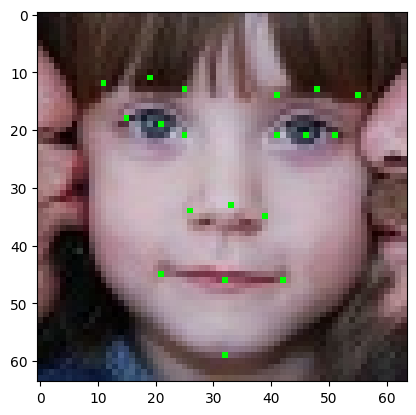

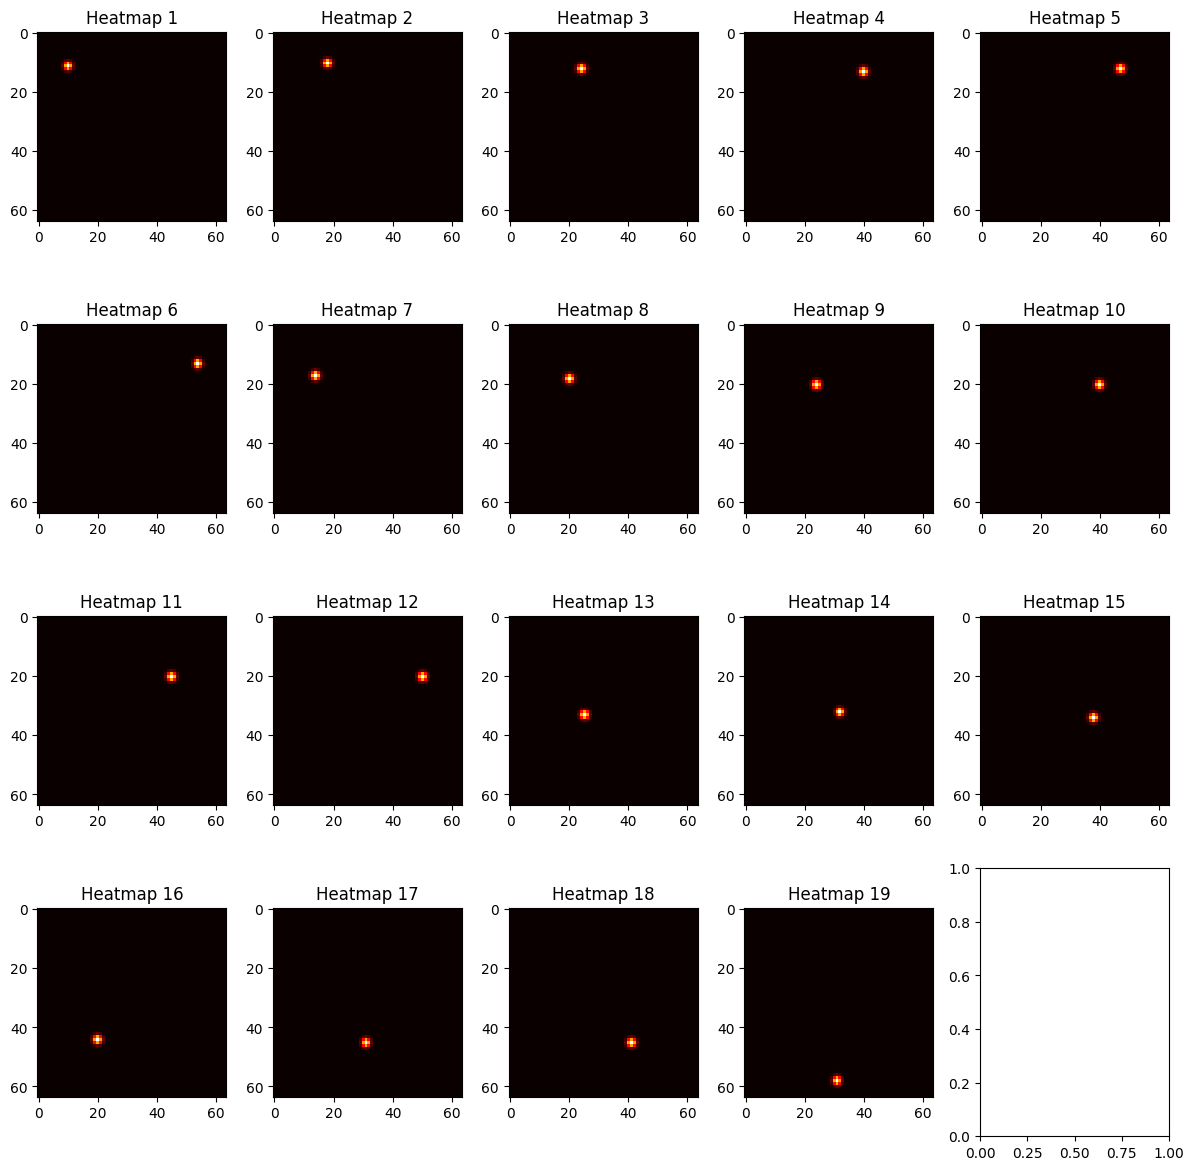

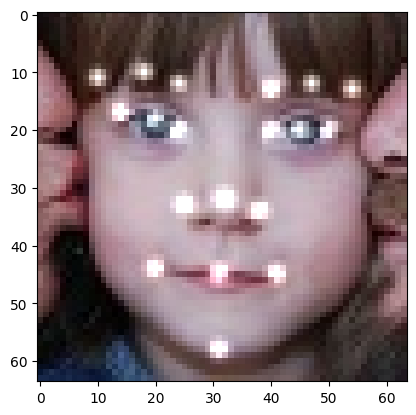

In [121]:
index = 2519
begin, end = 2519, 2519
visualize_keypoint(begin, end)
visualize_heatmap(index)

# Masked AutoEncoder

In [6]:
def patchify(images, patch_size=4):
    """Splitting images into patches.
    Args:
        images: Input tensor with size (batch, channels, height, width)
            We can assume that image is square where height == width.
    Returns:
        A batch of image patches with size (
          batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    """
    # BEGIN YOUR CODE
    _, _, height, width = images.shape
    new_height = height / patch_size 
    new_width = width / patch_size
    images = einops.rearrange(images, 'b c (h ps1) (w ps2) -> b (h w) (c ps1 ps2)', h = int(new_height), w = int(new_width)) 
    return images
    # END YOUR CODE

def unpatchify(patches, patch_size=4):
    """Combining patches into images.
    Args:
        patches: Input tensor with size (
        batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    Returns:
        A batch of images with size (batch, channels, height, width)
    """
    # BEGIN YOUR CODE
    _, x, y = patches.shape
    height = int(np.sqrt(x))
    width = height
    patches = einops.rearrange(patches, 'b (h w) (c ps1 ps2) -> b c (h ps1) (w ps2)', h = height , w = width, ps1 = patch_size, ps2 = patch_size)
    return patches
    
    # END YOUR CODE

In [20]:
class Transformer(nn.Module):
    """Transformer Encoder 
    Args:
        embedding_dim: dimension of embedding
        n_heads: number of attention heads
        n_layers: number of attention layers
        feedforward_dim: hidden dimension of MLP layer
    Returns:
        Transformer embedding of input
    """
    def __init__(self, embedding_dim=768, n_heads=12, n_layers=12, feedforward_dim=3072):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.feedforward_dim = feedforward_dim
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=self.n_heads,
                dim_feedforward=self.feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.1,
                norm_first=True
            ),
            num_layers=n_layers,
            norm=nn.LayerNorm(embedding_dim, eps=1e-6)
        )

    def forward(self, x):
        return self.transformer(x)

In [11]:
def index_sequence(x, ids):
    """Index tensor (x) with indices given by ids
    Args:
        x: input sequence tensor, can be 2D (batch x length) or 3D (batch x length x feature)
        ids: 2D indices (batch x length) for re-indexing the sequence tensor
    """
    if len(x.shape) == 3:
        ids = ids.unsqueeze(-1).expand(-1, -1, x.shape[-1])
#         print({'ids_shuffle_expand' : ids})
    return torch.take_along_dim(x, ids, dim=1)

def random_masking(x, keep_length, ids_shuffle):
    """Apply random masking on input tensor
    Args:
        x: input patches (batch x length x feature)
        keep_length: length of unmasked patches
        ids_shuffle: random indices for shuffling the input sequence 
    Returns:
        kept: unmasked part of x
        mask: a 2D (batch x length) mask tensor of 0s and 1s indicated which
            part of x is masked out. The value 0 indicates not masked and 1
            indicates masked.
        ids_restore: indices to restore x. If we take the kept part and masked
            part of x, concatentate them together and index it with ids_restore,
            we should get x back.

    Hint:
        ids_shuffle contains the indices used to shuffle the sequence (patches).
        You should use the provided index_sequence function to re-index the
        sequence, and keep the first keep_length number of patches.
    """
    # BEGIN YOUR CODE
    b, l, f = x.shape
#     print({'x' : x})
#     print({'ids_shuffle' : ids_shuffle})
    ids_restore = torch.argsort(ids_shuffle, dim = 1)
#     print({'ids_restore' : ids_restore})
    kept = index_sequence(x, ids_shuffle)
#     print({'kept': kept})
    kept = kept[:, :keep_length]
#     print({'kept_keep': kept})
    ids_kept = ids_shuffle[:, :keep_length]
#     print({'ids_kept': ids_kept})
    
    mask = torch.ones([b, l], device=x.device)
    mask[:, :keep_length] = 0
    mask = torch.gather(mask, dim=1, index = ids_restore)
#     print({'mask' : mask})
    return kept, mask, ids_restore
    # END YOUR CODE

def restore_masked(kept_x, masked_x, ids_restore):
    """Restore masked patches
    Args:
        kept_x: unmasked patches
        masked_x: masked patches
        ids_restore: indices to restore x
    Returns:
        restored patches
    """
    # BEGIN YOUR CODE
    x = torch.cat((kept_x, masked_x), dim = 1)
    x = torch.gather(x, dim = 1, index = ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))
    
    return x
    
    # END YOUR CODE

In [12]:
class MaskedAutoEncoder(nn.Module):
    """MAE Encoder
    Args:
        encoder: vit encoder
        decoder: vit decoder
        encoder_embedding_dim: embedding size of encoder
        decoder_embedding_dim: embedding size of decoder
        patch_size: image patch size
        num_patches: number of patches
        mask_ratio: percentage of masked patches
    """
    def __init__(self, encoder, decoder, encoder_embedding_dim=768, 
                 decoder_embedding_dim=512, patch_size=4, num_patches=16,
                 mask_ratio=0.75):
        super().__init__()
        self.encoder_embedding_dim = encoder_embedding_dim
        self.decoder_embedding_dim = decoder_embedding_dim
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio

        self.masked_length = int(num_patches * num_patches * mask_ratio)
        self.keep_length = num_patches * num_patches - self.masked_length

        self.encoder = encoder
        self.decoder = decoder

        self.encoder_input_projection = nn.Linear(patch_size * patch_size * 3, encoder_embedding_dim)
        self.decoder_input_projection = nn.Linear(encoder_embedding_dim, decoder_embedding_dim)
        self.decoder_output_projection = nn.Linear(decoder_embedding_dim, patch_size * patch_size * 3)
        self.cls_token = nn.Parameter(torch.randn(1, 1, encoder_embedding_dim))
        self.encoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, encoder_embedding_dim))
        self.decoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, decoder_embedding_dim))
        self.masked_tokens = nn.Parameter(torch.randn(1, 1, decoder_embedding_dim))

    def forward_encoder(self, images, ids_shuffle=None):
        """Encode input images
        You should implement the following steps
        (1) patchify images into patches
        (2) linear projection
        (3) add position encoding
        (4) concatenate cls_token and patches embedding and pass it to vit encoder
        """
        batch_size = images.shape[0]
        # Generate random shuffling indices
        if ids_shuffle is None:
            ids_shuffle = torch.argsort(
                torch.rand(
                    (batch_size, self.num_patches * self.num_patches),
                    device=images.device
                ),
                dim=1
            )
        # BEGIN YOUR CODE
        #1
        patches = patchify(images, self.patch_size)

        #2
        projection = self.encoder_input_projection(patches)

        #3
        b, n, l = projection.shape
        projection += self.encoder_position_encoding[:, :(n + 1)]

        #4
        kept, mask, ids_restore = random_masking(projection, n - self.masked_length, ids_shuffle)
        cls_tokens = einops.repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, kept), dim=1)
        encoder_output = self.encoder(x)
        
        return encoder_output, mask, ids_restore
        # END YOUR CODE

    def forward_decoder(self, encoder_embeddings, ids_restore):
        """Decode encoder embeddings
        You should implement the following steps
        (1) linear projection of encoder embeddings
        (2) restore sequence from masked_patches and encoder predictions
        (3) add position encoding
        (3) readd/use CLS token and decode using ViT decoder 
        (4) projection to predict image patches
        """
        # BEGIN YOUR CODE
        
        #1
        projection = self.decoder_input_projection(encoder_embeddings)
        b, n, l = projection.shape
        #2
        cls_tokens = projection[:, :1, :]
        embedding = projection[:, 1:, :]
        mask_tokens = self.masked_tokens.repeat(b, ids_restore.shape[1] - n + 1, 1)
        
        x = restore_masked(embedding, mask_tokens, ids_restore)
        
        #3
        b, n, l = x.shape
        x += self.decoder_position_encoding[:, :(n + 1)]
        
        #4
        x = torch.cat((cls_tokens, x), dim = 1)
        
        decoder_output = self.decoder(x)
        decoder_output = decoder_output[:, 1:, :]
        #5
        return self.decoder_output_projection(decoder_output)
        # END YOUR CODEc

    def forward(self, images):
        encoder_output, mask, ids_restore = self.forward_encoder(images)
        decoder_output = self.forward_decoder(encoder_output, ids_restore)
        return decoder_output, mask

    def forward_encoder_representation(self, images):
        """Encode images without applying random masking to get representation
        of input images. 

        You should implement splitting images into patches, readd/use CLS token,
        and encoding with ViT encoder.
        """
        # BEGIN YOUR CODE
        patches = patchify(images)

        #2
        projection = self.encoder_input_projection(patches)

        #3
        b, n, l = projection.shape
        projection += self.encoder_position_encoding[:, :(n + 1)]

        #4
        cls_tokens = einops.repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, projection), dim=1)
        encoder_output = self.encoder(x)
        return encoder_output
        # END YOUR CODE

In [ ]:
a = torch.LongTensor(2, 16, 5).random_(0, 10)
b = torch.argsort(torch.rand((2, 16)), dim = 1)
c = random_masking(a,  4, b)
print({'a': a, 'b' : b, 'c' : c})

* ## Define MAE Model

In [12]:
# Initilize MAE model
# encoder, decoder, encoder_embedding_dim=256, decoder_embedding_dim=128, patch_size=4, num_patches=16
model = MaskedAutoEncoder(
    Transformer(embedding_dim=768, n_layers=12, n_heads=12, feedforward_dim=768*4),
    Transformer(embedding_dim=512, n_layers=4, n_heads=16, feedforward_dim=512*4), encoder_embedding_dim=768, decoder_embedding_dim=512, patch_size=4, num_patches=16
)
# Move the model to GPU
model.to(device)

MaskedAutoEncoder(
  (encoder): Transformer(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    )
  )
  (decoder): Transformer(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
 

# Pretrain

In [13]:
optim = torch.optim.AdamW(model.parameters(), lr= BASE_LR * BATCH_SIZE / 256, betas=(0.9, 0.95), weight_decay=WEIGHT_DECAY)
lr_func = lambda epoch: min((epoch + 1) / (WARMUP_EPOCH) + 1e-8, 0.5 * (math.cos(epoch / TOTAL_EPOCH * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)

Adjusting learning rate of group 0 to 9.3750e-08.


In [ ]:
run = wandb.init(project=PROJECT_NAME, resume=True)

In [15]:
epoch = 0
if RESUME == True:
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [ ]:
while epoch < TOTAL_EPOCH:
    model.train()
    losses = []
    print('Epoch ' + str(epoch))
    data_iterator = tqdm(train_dataloader)
    for x, y, _, _ in data_iterator:
        x = x.to(device)
        image_patches = patchify(x, patch_size=4)
        predicted_patches, mask = model(x)
        loss = torch.sum(torch.mean(torch.square(image_patches - predicted_patches), dim=-1) * mask) / mask.sum()
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        data_iterator.set_postfix(loss=np.mean(losses))
    lr_scheduler.step()
    avg_loss = sum(losses) / len(losses)
    print(f'In epoch {epoch}, average traning loss is {avg_loss}.')
    wandb.log({'mae_loss': avg_loss}, step=epoch)
    
    model.eval()
    with torch.no_grad():
        val_img = torch.stack([val_dataset[i][0] for i in range(16)])
        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)
        mask = unpatchify(mask.unsqueeze(-1).tile(dims=(1,1,48)), 4)
        predicted_val_img = unpatchify(predicted_val_img, 4)
        predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
        img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
        img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
        images = wandb.Image(img)
        wandb.log({"mae_image": images}, step=epoch)
    
    # Periodically save model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict(),
        'loss': avg_loss
    }, CHECKPOINT_PATH)
    
    epoch += 1
    
    clear_output()

In [ ]:
model.eval()
with torch.no_grad():
    val_img = torch.stack([val_dataset[i][0] for i in range(16)])
    val_img = val_img.to(device)
    predicted_val_img, mask = model(val_img)
    mask = unpatchify(mask.unsqueeze(-1).tile(dims=(1,1,48)), 4)
    predicted_val_img = unpatchify(predicted_val_img, 4)
    predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
    print(predicted_val_img.shape)
    plt.figure()
    plt.imshow(predicted_val_img[0].squeeze(0).cpu().permute(1, 2, 0))

In [ ]:
from IPython.display import FileLink
FileLink(r'checkpoint_mae_pretrained.pt')

In [15]:
import torch
checkpoint = torch.load('/kaggle/working/checkpoint_mae_pretrained.pt')
epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(epoch, loss)

970 0.003810746108740568


# Finetuning

* ## Save UNetR_Encoder from MAE Encoder

In [14]:
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
class UNETR_Encoder(nn.Module):
    def __init__(self, model_pretrained):
        super().__init__()
        self.layers = model_pretrained.encoder.transformer.layers
        self.encoder_input_projection = model_pretrained.encoder_input_projection
        self.encoder_position_encoding = model_pretrained.encoder_position_encoding
        self.cls_token = model_pretrained.cls_token
        self.ext_layers = [3, 6, 9, 12]
    
    def forward(self, images):
        patches = patchify(images)
        projection = self.encoder_input_projection(patches)
        b, n, l = projection.shape
        projection += self.encoder_position_encoding[:, :(n + 1)]
        cls_tokens = einops.repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, projection), dim=1)

        hidden_states = x
        extract_layers = []
        for i, layer in enumerate(self.layers):
            hidden_states = layer(hidden_states)
            if i + 1 in self.ext_layers:
                extract_layers.append(hidden_states)
        return extract_layers

In [17]:
torch.save(UNETR_Encoder(model), 'UNETR_Encoder.pt')

In [ ]:
from IPython.display import FileLink
FileLink(r'UNETR_Encoder.pt')

* ## UNetR

In [7]:
class SingleDeconv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)
    
class SingleConv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)
    
class Conv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv2DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

class Deconv2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv2DBlock(in_planes, out_planes),
            SingleConv2DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)

In [8]:
class UNETR_Encoder(nn.Module):
    def __init__(self, embedding_dim=768, n_heads = 12, n_layers = 12, feedforward_dim = 768*4, patch_size=4, num_patches=16):
        super().__init__()
        self.layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=n_heads,
                dim_feedforward=feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.1,
                norm_first=True
            ),
            num_layers=n_layers,
            norm=nn.LayerNorm(embedding_dim, eps=1e-6)
        ).layers
        self.encoder_input_projection = nn.Linear(patch_size * patch_size * 3, embedding_dim)
        self.encoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, embedding_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.ext_layers = [3, 6, 9, 12]
    
    def forward(self, images):
        patches = patchify(images)
        projection = self.encoder_input_projection(patches)
        b, n, l = projection.shape
        projection += self.encoder_position_encoding[:, :(n + 1)]
        cls_tokens = einops.repeat(self.cls_token, '1 n d -> b n d', b = b)
        x = torch.cat((cls_tokens, projection), dim=1)

        hidden_states = x
        extract_layers = []
        for i, layer in enumerate(self.layers):
            hidden_states = layer(hidden_states)
            if i + 1 in self.ext_layers:
                extract_layers.append(hidden_states)
        return extract_layers

In [9]:
# Tham khảo ở đây (bỏ z3, z9)
# https://github.com/tamasino52/UNETR/blob/main/unetr.py

class UNETR(nn.Module):
    def __init__(self, encoder, input_dim=3, output_dim=3, embed_dim=768, patch_dim=(16, 16)):
        super().__init__()
        self.patch_dim = patch_dim
        self.encoder = encoder

        self.decoder0 = \
            nn.Sequential(
                Conv2DBlock(input_dim, 32, 3),
                Conv2DBlock(32, 64, 3)
            )

        self.decoder6 = Deconv2DBlock(embed_dim, 128)

        self.decoder12_upsampler = \
            SingleDeconv2DBlock(embed_dim, 128)


        self.decoder6_upsampler = \
            nn.Sequential(
                Conv2DBlock(256, 128),
                Conv2DBlock(128, 128),
                SingleDeconv2DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv2DBlock(128, 64),
                Conv2DBlock(64, 64),
                SingleConv2DBlock(64, output_dim, 1)
            )

    
    def forward(self, images):
        z = self.encoder(images)
        z0, z3, z6, z9, z12 = images, *z
        z6, z12 = z6[:, 1:, :], z12[:, 1:, :]

        arranger = lambda z_emb: rearrange(z_emb, 'b (x y) d -> b d x y',
                                           x=self.patch_dim[0], y=self.patch_dim[1])
        
        z6, z12 = map(arranger, (z6, z12))
        
        z12 = self.decoder12_upsampler(z12)
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z12], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z6], dim=1))
        return output

In [46]:
UNetR_Encoder = torch.load('UNETR_Encoder.pt')
model_finetune = UNETR(UNetR_Encoder, 3, 19)
model_finetune.to(device)
clear_output()

* ## Dataset and DataLoader for Finetuning

In [10]:
# 1000 samples
from torchvision.transforms import ToTensor, Compose, Normalize
finetune_train_dataset = AFLW(TRAIN_ANNOTATION_FILE, TRAIN_IMG_DIR, max_samples=1000,transform=Compose([ToTensor()])) # Normalize(meanstd['mean'], meanstd['std'])
finetune_val_dataset = AFLW(TEST_ANNOTATION_FILE, TEST_IMG_DIR, max_samples=1000, transform=Compose([ToTensor()]))

finetune_train_dataloader = DataLoader(finetune_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
finetune_val_dataloader = DataLoader(finetune_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [23]:
# 100 samples
from torchvision.transforms import ToTensor, Compose, Normalize
finetune_train_dataset = AFLW(TRAIN_ANNOTATION_FILE, TRAIN_IMG_DIR, max_samples=100,transform=Compose([ToTensor()])) # Normalize(meanstd['mean'], meanstd['std'])
finetune_val_dataset = AFLW(TEST_ANNOTATION_FILE, TEST_IMG_DIR, max_samples=100, transform=Compose([ToTensor()]))

finetune_train_dataloader = DataLoader(finetune_train_dataset, batch_size=4, shuffle=True, num_workers=2)
finetune_val_dataloader = DataLoader(finetune_val_dataset, batch_size=4, shuffle=True, num_workers=2)

* ## Loss
Adaptive Wing Loss

In [11]:
# https://github.com/SeungyounShin/Adaptive-Wing-Loss-for-Robust-Face-Alignment-via-Heatmap-Regression/blob/master/losses/loss.py

class AWing(nn.Module):

    def __init__(self, alpha=2.1, omega=14, epsilon=1, theta=0.5):
        super().__init__()
        self.alpha   = float(alpha)
        self.omega   = float(omega)
        self.epsilon = float(epsilon)
        self.theta   = float(theta)

    def forward(self, y_pred , y):
        lossMat = torch.zeros_like(y_pred)
        A = self.omega * (1/(1+(self.theta/self.epsilon)**(self.alpha-y)))*(self.alpha-y)*((self.theta/self.epsilon)**(self.alpha-y-1))/self.epsilon
        C = self.theta*A - self.omega*torch.log(1+(self.theta/self.epsilon)**(self.alpha-y))
        case1_ind = torch.abs(y-y_pred) < self.theta
        case2_ind = torch.abs(y-y_pred) >= self.theta
        lossMat[case1_ind] = self.omega*torch.log(1+torch.abs((y[case1_ind]-y_pred[case1_ind])/self.epsilon)**(self.alpha-y[case1_ind]))
        lossMat[case2_ind] = A[case2_ind]*torch.abs(y[case2_ind]-y_pred[case2_ind]) - C[case2_ind]
        return lossMat

class Loss_weighted(nn.Module):
    def __init__(self, W=10, alpha=2.1, omega=14, epsilon=1, theta=0.5):
        super().__init__()
        self.W = float(W)
        self.Awing = AWing(alpha, omega, epsilon, theta)

    def forward(self, y_pred , y, M):
        M = M.float()
        Loss = self.Awing(y_pred,y)
        weighted = Loss * (self.W * M + 1.)
        return weighted.mean()

* ## Metric
NME

In [12]:
def compute_nme(preds, meta):

    targets = meta['pts'] * IMG_SIZE
    preds = preds.numpy()
    target = targets.cpu().numpy()

    N = preds.shape[0]
    L = preds.shape[1]
    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt, axis=1)) / L

    return rmse

* # Post Processing

In [13]:
# https://github.com/HRNet/HRNet-Facial-Landmark-Detection/blob/master/lib/core/evaluation.py

def get_preds(scores):
    """
    get predictions from score maps in torch Tensor
    scores: [batch_size, num_joints, height, width]
    return type: torch.LongTensor
    """
    assert scores.dim() == 4, 'Score maps should be 4-dim'
    maxval, idx = torch.max(scores.view(scores.size(0), scores.size(1), -1), 2)

    maxval = maxval.view(scores.size(0), scores.size(1), 1)
    idx = idx.view(scores.size(0), scores.size(1), 1) + 1

    preds = idx.repeat(1, 1, 2).float()

    preds[:, :, 0] = (preds[:, :, 0] - 1) % scores.size(3) + 1
    preds[:, :, 1] = torch.floor((preds[:, :, 1] - 1) / scores.size(3)) + 1

    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask
    return preds

def decode_preds(output, res=(IMG_SIZE, IMG_SIZE)):
    coords = get_preds(output)  # float type

    coords = coords.cpu()
    # pose-processing
    for n in range(coords.size(0)):
        for p in range(coords.size(1)):
            hm = output[n][p]
            px = int(math.floor(coords[n][p][0]))
            py = int(math.floor(coords[n][p][1]))
            if (px > 1) and (px < res[0]) and (py > 1) and (py < res[1]):
                diff = torch.Tensor([hm[py - 1][px] - hm[py - 1][px - 2], hm[py][px - 1]-hm[py - 2][px - 1]])
                coords[n][p] += diff.sign() * .25
    coords += 0.5
    preds = coords.clone()

    if preds.dim() < 3:
        preds = preds.view(1, preds.size())

    return preds

## Train, Validate One Epoch and Save Checkpoint Function

In [15]:
def train_one_epoch(model, epoch, dataloader, criterion, optimizer, step_dict, device, lr_scheduler = None):
    model.train()
    nme_count = 0
    nme_batch_sum = 0
    losses = []
    data_iterator = tqdm(dataloader)
    for x, y, M, meta in data_iterator:
        x = x.to(device)
        y = y.to(device)
        M = M.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y, M)

        # compute nme
        preds = decode_preds(y_pred)
        nme_batch = compute_nme(preds, meta)
        nme_batch_sum += nme_batch.sum()
        nme_count += preds.shape[0]

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        data_iterator.set_postfix(loss=np.mean(losses))

        step_dict['train_global_steps'] += 1
        
    if lr_scheduler is not None:
        lr_scheduler.step()

    nme = nme_batch_sum / nme_count
    print(f'Train epoch {epoch}, avg loss : {np.mean(losses)}, nme : {nme}.')
    return np.mean(losses), nme

def val_one_epoch(model, epoch, dataloader, criterion, step_dict, device):
    model.eval()
    nme_count = 0
    nme_batch_sum = 0
    losses = []
    data_iterator = tqdm(dataloader)
    with torch.no_grad():
        for x, y, M, meta in data_iterator:
            x = x.to(device)
            y = y.to(device)
            M = M.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y, M)

            # compute nme
            preds = decode_preds(y_pred)
            nme_batch = compute_nme(preds, meta)
            nme_batch_sum += nme_batch.sum()
            nme_count += preds.shape[0]

            losses.append(loss.item())
            data_iterator.set_postfix(loss=np.mean(losses))

            step_dict['val_global_steps'] += 1

    nme = nme_batch_sum / nme_count
    print(f'Val epoch {epoch}, avg loss : {np.mean(losses)}, nme : {nme}.')
    return np.mean(losses), nme

def save_checkpoint(model, optimizer, epoch, loss, nme, step_dict, filename, lr_scheduler= None):
    save_dict = {}
    if lr_scheduler is not None:
        save_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'loss': loss,
            'nme': nme,
            'step_dict': step_dict
        }
    else:
        save_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'nme': nme,
            'step_dict': step_dict
        }
    torch.save(save_dict, filename)

In [14]:
# 1000 samples
RESUME_FINETUNE = True
CHECKPOINT_PATH_FINETUNE = 'checkpoint_finetune_2.pt'
WARMUP_EPOCH_FINETUNE = 20
TOTAL_EPOCH_FINETUNE = 200

In [27]:
# 100 samples
RESUME_FINETUNE = False
CHECKPOINT_PATH_FINETUNE = 'checkpoint_finetune_100_samples.pt'
WARMUP_EPOCH_FINETUNE = 20
TOTAL_EPOCH_FINETUNE = 100

In [23]:
step_dict = {
        'train_global_steps': 0,
        'val_global_steps': 0
}

criterion = Loss_weighted()

# 1000 samples
optim = torch.optim.AdamW(model_finetune.parameters(), lr= BASE_LR * BATCH_SIZE / 256, betas=(0.9, 0.95), weight_decay=WEIGHT_DECAY)
lr_func = lambda epoch: min((epoch + 1) / (WARMUP_EPOCH_FINETUNE) + 1e-8, 0.5 * (math.cos(epoch / TOTAL_EPOCH_FINETUNE * math.pi) + 1))

# 100 samples
# optim = torch.optim.AdamW(model_finetune.parameters(), lr= BASE_LR, betas=(0.9, 0.95), weight_decay=WEIGHT_DECAY)
# lr_func = lambda epoch: min((epoch + 1) / (WARMUP_EPOCH_FINETUNE) + 1e-4, 0.5 * (math.cos(epoch / TOTAL_EPOCH_FINETUNE * math.pi) + 1))

lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)

run = wandb.init(project=PROJECT_NAME, resume=True)

wandb: Currently logged in as: tuyenld. Use `wandb login --relogin` to force relogin


Adjusting learning rate of group 0 to 4.6875e-07.


* # Finetuning

In [ ]:
epoch = 0
loss = 0
if RESUME_FINETUNE == True:
    checkpoint = torch.load(CHECKPOINT_PATH_FINETUNE)
    model_finetune.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    nme = checkpoint['nme']
    step_dict = checkpoint['step_dict']

print(epoch, loss)

while True:
        train_loss, nme_train = train_one_epoch(model_finetune, epoch, finetune_train_dataloader, criterion, optim, step_dict, device, lr_scheduler)
        val_loss, nme_val = val_one_epoch(model_finetune, epoch, finetune_val_dataloader, criterion, step_dict, device)
        wandb.log({'train_loss': train_loss, 'val_loss': val_loss}, step=epoch)
        wandb.log({'nme_train': nme_train, 'nme_val': nme_val}, step=epoch)
        save_checkpoint(model_finetune, optim, epoch, train_loss, val_loss, step_dict, CHECKPOINT_PATH_FINETUNE, lr_scheduler)
        epoch += 1
        clear_output()

  0%|          | 0/63 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.2497e-09.
Train epoch 194, avg loss : 0.028632030600593203, nme : 1.0597264508197186.


  0%|          | 0/63 [00:00<?, ?it/s]

In [15]:
checkpoint = torch.load(CHECKPOINT_PATH_FINETUNE)

In [16]:
model_finetune = UNETR(UNETR_Encoder(), 3, 19)
model_finetune.to(device)
model_finetune.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Test Post-processing. NME, AWing Loss and Inference

In [34]:
train_img, train_labels, M, meta = next(iter(finetune_val_dataloader))
print(f"Feature batch shape: {train_img.shape}")
print(f"Labels batch shape: {train_labels.shape}")
print(f"M shape: {M.shape}")

Feature batch shape: torch.Size([16, 3, 64, 64])
Labels batch shape: torch.Size([16, 19, 64, 64])
M shape: torch.Size([16, 19, 64, 64])


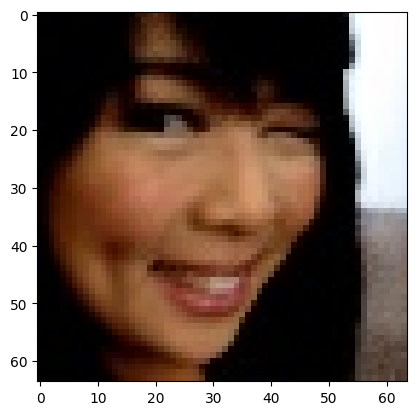

In [42]:
plt.imshow(train_img[4].squeeze().permute(1, 2, 0))

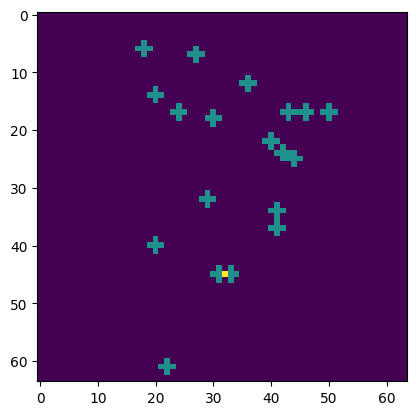

In [22]:
# Test Weighted loss map
plt.imshow(torch.sum(M[4], axis=[0], keepdims=True).permute(1, 2, 0))

In [21]:
decode_preds(train_labels[4].unsqueeze(0))

tensor([[[19.5000,  7.5000],
         [28.5000,  8.5000],
         [37.5000, 13.5000],
         [44.5000, 18.5000],
         [47.5000, 18.5000],
         [51.5000, 18.5000],
         [21.5000, 15.5000],
         [25.5000, 18.5000],
         [31.5000, 19.5000],
         [41.5000, 23.5000],
         [43.5000, 25.5000],
         [45.5000, 26.5000],
         [30.5000, 33.5000],
         [42.5000, 35.5000],
         [42.5000, 38.5000],
         [21.5000, 41.5000],
         [32.5000, 46.5000],
         [34.5000, 46.5000],
         [23.5000, 62.5000]]])

In [20]:
meta['pts'][4] * 64

tensor([[19.7874,  7.3691],
        [28.7359,  8.9071],
        [37.2649, 13.6610],
        [44.1161, 18.6945],
        [47.1921, 18.4148],
        [51.2469, 18.2750],
        [21.1856, 15.7583],
        [25.9395, 18.9741],
        [31.3925, 19.9529],
        [41.7391, 23.8678],
        [43.5568, 25.2660],
        [45.3744, 26.3846],
        [30.2739, 33.6552],
        [42.4382, 35.4728],
        [42.3417, 38.3362],
        [21.1856, 41.4851],
        [32.7907, 46.9381],
        [34.9096, 46.4713],
        [23.2357, 62.3694]])

In [27]:
np.mean(compute_nme(decode_preds(train_labels), meta))

0.41377561970760945

In [28]:
model_finetune.eval()
with torch.no_grad():
#     print(np.mean(compute_nme(decode_preds(model_finetune(train_img.to(device))), meta)))
    print(decode_preds(model_finetune(train_img[4].unsqueeze(0).to(device))))

tensor([[[24.7500,  8.2500],
         [26.7500, 10.2500],
         [28.2500, 11.2500],
         [35.2500, 12.7500],
         [42.2500, 13.7500],
         [47.7500, 16.7500],
         [26.2500, 16.7500],
         [27.2500, 17.2500],
         [28.2500, 17.7500],
         [37.2500, 19.7500],
         [40.2500, 21.7500],
         [45.2500, 23.7500],
         [21.2500, 31.2500],
         [21.7500, 29.2500],
         [32.7500, 35.7500],
         [23.2500, 42.2500],
         [23.7500, 43.2500],
         [35.2500, 48.7500],
         [25.2500, 61.7500]]])


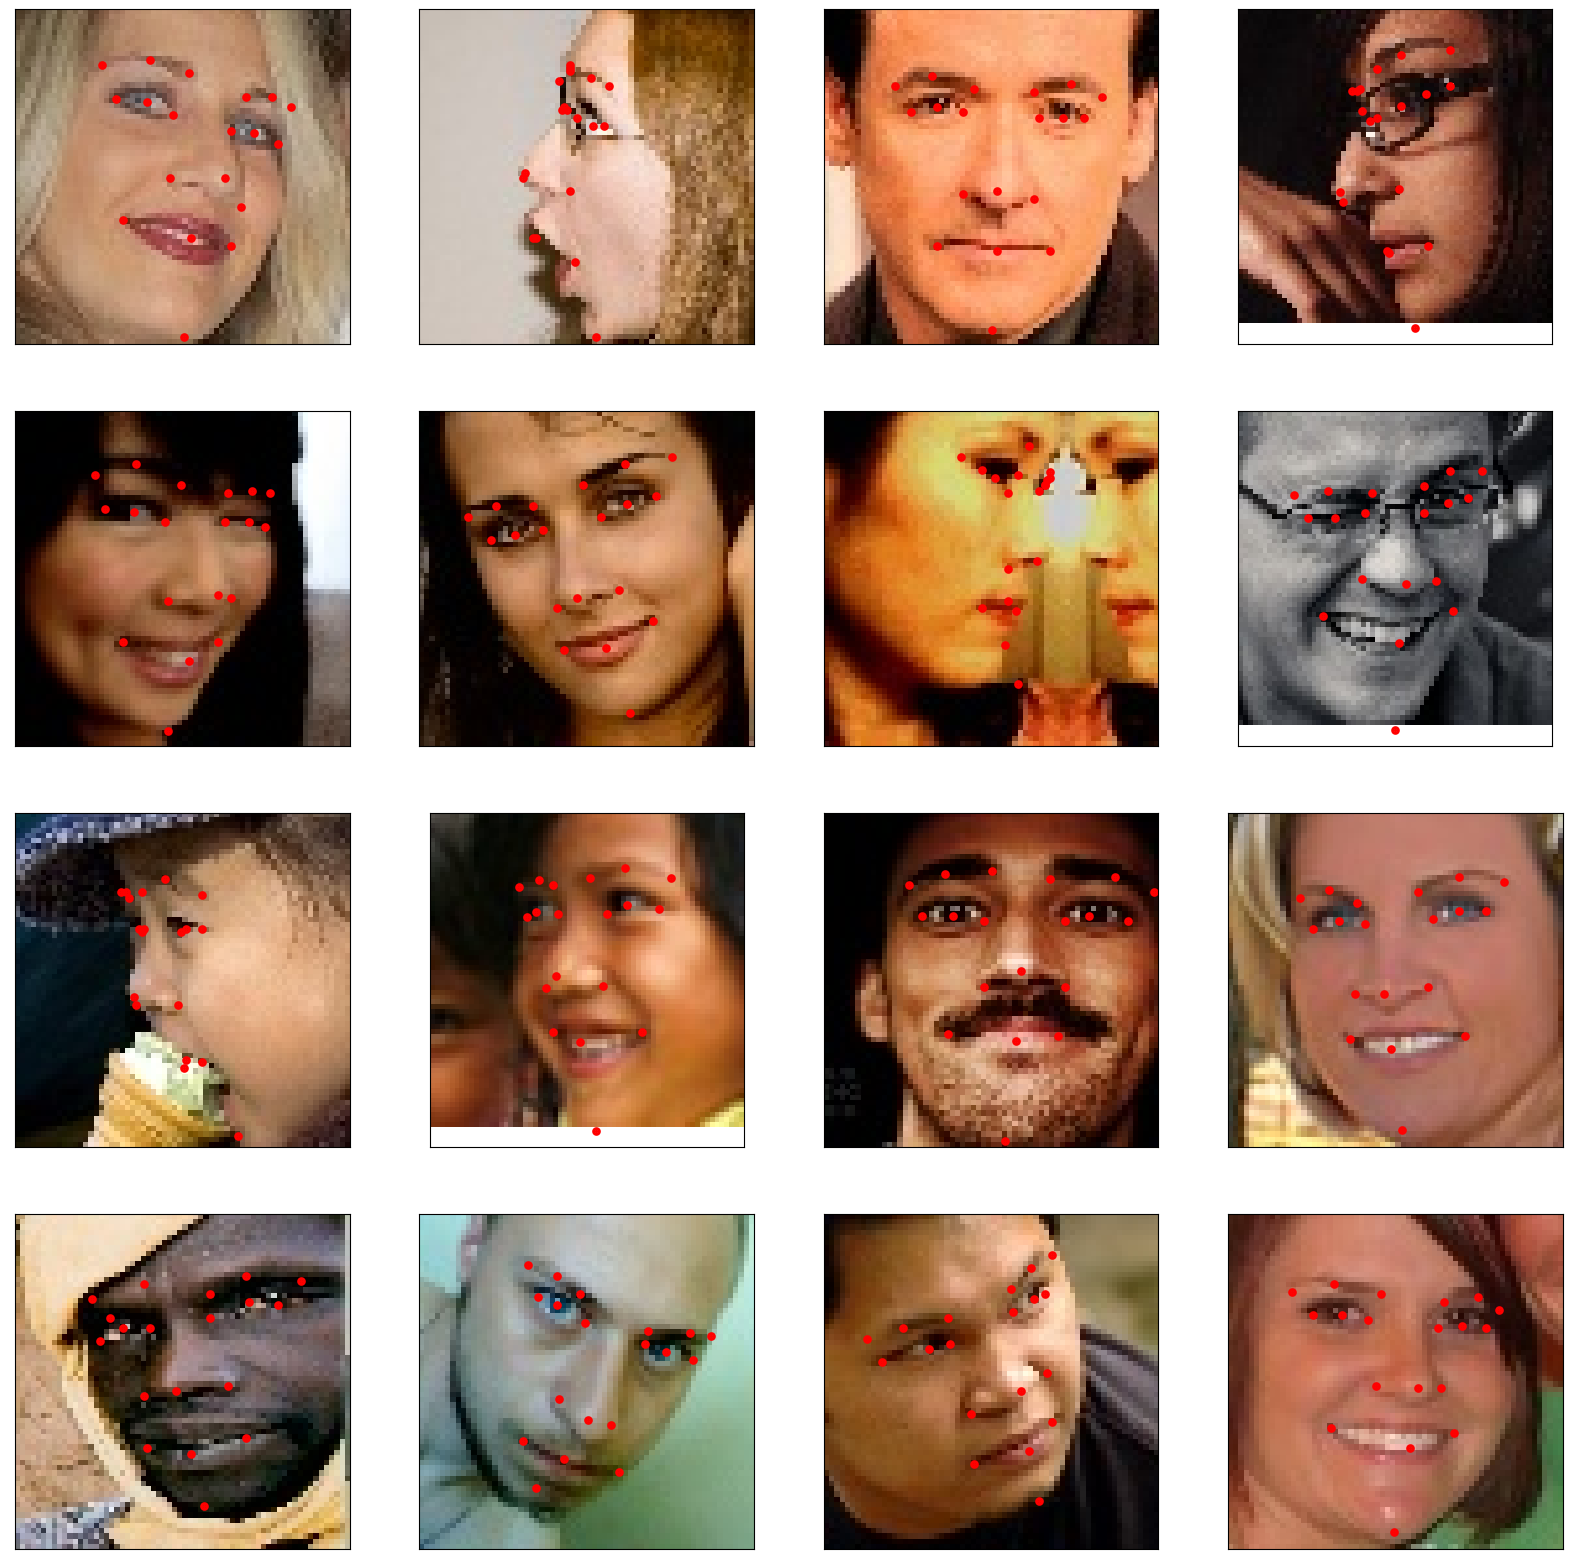

In [35]:
# Visualize the model's predictions

# We'll take a batch of 16 images and convert them to a grid for visualization
def visualize_output(images, model):
    with torch.no_grad():
        model.eval()
        images = images.to(device)
        preds = model(images)
        preds = decode_preds(preds)
        preds = preds.cpu().numpy()
        images = images.cpu().numpy()
        fig = plt.figure(figsize=(20, 20))
        for idx in np.arange(16):
            ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
            ax.imshow(np.squeeze(images[idx]).transpose(1, 2, 0))
            ax.scatter(preds[idx][:, 0], preds[idx][:, 1], s=20, marker='.', c='r', linewidths=4)

visualize_output(train_img, model_finetune)

# Train without pretrain MAE (From Scratch)

In [ ]:
UNETR_Scratch = UNETR(UNETR_Encoder(), 3, 19)

UNETR_Scratch.to(device)

model_graph = draw_graph(UNETR_Scratch, input_size=(4, 3, IMG_SIZE, IMG_SIZE), device=device)
model_graph.visual_graph

In [16]:
# 1000 samples
from torchvision.transforms import ToTensor, Compose, Normalize
scratch_train_dataset = AFLW(TRAIN_ANNOTATION_FILE, TRAIN_IMG_DIR, max_samples=1000,transform=Compose([ToTensor()])) # Normalize(meanstd['mean'], meanstd['std'])
scratch_val_dataset = AFLW(TEST_ANNOTATION_FILE, TEST_IMG_DIR, max_samples=1000, transform=Compose([ToTensor()]))

scratch_train_dataloader = DataLoader(scratch_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
scratch_val_dataloader = DataLoader(scratch_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [44]:
# 100 samples
from torchvision.transforms import ToTensor, Compose, Normalize
scratch_train_dataset = AFLW(TRAIN_ANNOTATION_FILE, TRAIN_IMG_DIR, max_samples=100,transform=Compose([ToTensor()])) # Normalize(meanstd['mean'], meanstd['std'])
scratch_val_dataset = AFLW(TEST_ANNOTATION_FILE, TEST_IMG_DIR, max_samples=100, transform=Compose([ToTensor()]))

scratch_train_dataloader = DataLoader(scratch_train_dataset, batch_size=4, shuffle=True, num_workers=2)
scratch_val_dataloader = DataLoader(scratch_val_dataset, batch_size=4, shuffle=True, num_workers=2)

In [45]:
RESUME_TRAIN_SCRATCH = False
CHECKPOINT_PATH_SCRATCH = 'checkpoint_train_scratch_100_samples.pt'

In [46]:
step_dict = {
        'train_global_steps': 0,
        'val_global_steps': 0
}

criterion = Loss_weighted()

# 1000 samples
# optim = torch.optim.AdamW(UNETR_Scratch.parameters(), lr= BASE_LR * BATCH_SIZE / 256, betas=(0.9, 0.95), weight_decay=WEIGHT_DECAY)
# 100 samples
optim = torch.optim.AdamW(UNETR_Scratch.parameters(), lr= BASE_LR, betas=(0.9, 0.95), weight_decay=WEIGHT_DECAY)
# lr_func = lambda epoch: min((epoch + 1) / (WARMUP_EPOCH_FINETUNE) + 1e-8, 0.5 * (math.cos(epoch / TOTAL_EPOCH_FINETUNE * math.pi) + 1))
# lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)

run = wandb.init(project=PROJECT_NAME)

nme_train,▇▇███▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nme_val,▇▇███▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nme_train,0.52739
nme_val,3.72221
train_loss,0.003
val_loss,0.08653


In [ ]:
epoch = 0
loss = 0
if RESUME_TRAIN_SCRATCH == True:
    checkpoint = torch.load(CHECKPOINT_PATH_SCRATCH)
    model_finetune.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    nme = checkpoint['nme']
    step_dict = checkpoint['step_dict']

print(epoch, loss)

while True:
        train_scratch_loss, nme_train_scratch = train_one_epoch(UNETR_Scratch, epoch, scratch_train_dataloader, criterion, optim, step_dict, device)
        val_scratch_loss, nme_val_scratch = val_one_epoch(UNETR_Scratch, epoch, scratch_val_dataloader, criterion, step_dict, device)
        wandb.log({'train_scratch_loss': train_scratch_loss, 'val_scratch_loss': val_scratch_loss}, step=epoch)
        wandb.log({'nme_train_scratch': nme_train_scratch, 'nme_val_scratch': nme_val_scratch}, step=epoch)
        save_checkpoint(UNETR_Scratch, optim, epoch, train_scratch_loss, nme_train_scratch, step_dict, CHECKPOINT_PATH_SCRATCH)
        epoch += 1
        clear_output()